# Deep Learning Exam - Motion Debluring
## Lorenzo Balzani
### January 14, 2024

# Setup

In [34]:
from typing import Generator, Tuple, Any, List, Dict, Union

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import EarlyStopping

checkpoint_name: str = "custom_deblurring_model.keras"

#random_state: int = 42
#np.random.seed(random_state)
#tf.random.set_seed(random_state)

# Dataset

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train/255.).astype(np.float32)
x_test = (x_test/255.).astype(np.float32)

x_validation = x_train[50000:, :, :]
x_train = x_train[:50000, :, :]

11490434/11490434 [==============================] - 0s 0us/step


## Dataset Generator

In [3]:
def generator(dataset,batchsize: int, moves: int=10):
  while True:
    rand = np.random.randint(dataset.shape[0],size=batchsize)
    y_truth = dataset[rand]
    blurred = np.copy(y_truth)
    moving = tf.expand_dims(y_truth,axis=-1)

    for i in range(moves):
      #RandomTranslation requires a channel axis
      moving = layers.RandomTranslation(0.07,0.07,fill_mode='constant',interpolation='bilinear')(moving)
      blurred = blurred + tf.squeeze(moving)
    blurred = blurred/(moves+1)
    yield(blurred,y_truth)

# My Solution: Model Definition

## Hyperparameters Choices
- Activation Function: Rectified Linear Unit (ReLU) is chosen as the activation function for all convolutional layers, introducing non-linearity to the model.
- Batch Normalization: Applied after each ReLU activation to improve convergence and generalization by normalizing layer inputs.
- Padding: 'Same' padding is used in convolutional layers to maintain spatial dimensions.
- Kernel Sizes: Different kernel sizes are used in convolutional layers, ranging from (7, 7) to (3, 3). This allows the model to capture features at different scales.
- Number of Filters: The number of filters in each layer gradually decreases, potentially capturing high-level features in deeper layers.
- Final Activation: Linear activation is chosen for the output layer, indicating a regression task where the model predicts continuous values.

In [4]:
def build_deblurring_model(input_shape: Tuple[int, int, int],
                          filters: List[Tuple[int, tuple[int, int], Any]],
                          final_filter: Dict[str, Union[int, str, Tuple[int, int]]],
                          optimizer: tf.optimizers.Optimizer,
                          loss: str,
                          metrics: List[str]) -> tf.keras.models.Model:
    model = Sequential()

    for num_filters, filter_size, activation in filters:
        model.add(Conv2D(num_filters, filter_size, padding="same", input_shape=input_shape))
        model.add(activation)
        model.add(BatchNormalization())

    model.add(Conv2D(final_filter["num_filters"], final_filter["filter_size"], activation=final_filter["activation"], padding="same"))
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model


input_shape: Tuple[int, int, int] = (28, 28, 1)
custom_deblurring_model = build_deblurring_model(input_shape,
                                                [(32, (7, 7), ReLU()), (64, (5, 5), ReLU()), (128, (5, 5), ReLU()), (256, (3, 3), ReLU()),
                                                (128, (3, 3), ReLU()), (64, (7, 7), ReLU()), (32, (5, 5), ReLU()), (16, (3, 3), ReLU())],
                                                {
                                                  "num_filters": 1,
                                                  "filter_size": (3, 3),
                                                  "activation": "linear"
                                                },
                                                tf.keras.optimizers.Adam(5E-4),
                                                "mean_squared_error",
                                                ["mse"]
                                                 )
custom_deblurring_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        1600      
                                                                 
 re_lu (ReLU)                (None, 28, 28, 32)        0         
                                                                 
 batch_normalization (Batch  (None, 28, 28, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        51264     
                                                                 
 re_lu_1 (ReLU)              (None, 28, 28, 64)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 28, 28, 64)        256       
 chNormalization)                                       

# My Solution: Model Training

### 20 Epochs With Batchsize = 128

A batch size of 128 strikes a balance between computational efficiency and model generalization.
Larger batches provide computational speed-ups but may sacrifice generalization. Smaller batches can introduce noise but might help the model generalize better.
Choosing 128 is a compromise, leveraging parallelism in GPUs without sacrificing too much on generalization.

In [10]:
def train_custom_model(train_generator: Generator[Tuple, None, None],
                       epochs: int,
                       validation_generator: Generator[Tuple, None, None],
                       steps_per_epoch: int,
                       validation_steps: int,
                       verbose: int = 1):
    tf.debugging.disable_traceback_filtering()
    train_history  = custom_deblurring_model.fit(train_generator,
                                epochs=epochs,
                                validation_data=validation_generator,
                                steps_per_epoch=steps_per_epoch,
                                validation_steps=validation_steps,
                                callbacks=EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True),
                                verbose=verbose)
    return train_history

train_batch_size: int = 128
eval_batch_size: int = 128
epochs: int = 5

train_generator = generator(x_train, train_batch_size)
validation_generator = generator(x_validation, eval_batch_size)

train_history = train_custom_model(train_generator,
                   epochs=epochs,
                   validation_generator=validation_generator,
                   steps_per_epoch=len(x_train)//train_batch_size,
                   validation_steps=len(x_validation)//eval_batch_size)

custom_deblurring_model.save(checkpoint_name)

Epoch 1/5
390/390 [==============================] - 116s 287ms/step - loss: 0.0699 - mse: 0.0699 - val_loss: 0.0782 - val_mse: 0.0782
Epoch 2/5
390/390 [==============================] - 107s 275ms/step - loss: 0.0332 - mse: 0.0332 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 3/5
390/390 [==============================] - 111s 286ms/step - loss: 0.0266 - mse: 0.0266 - val_loss: 0.0262 - val_mse: 0.0262
Epoch 4/5
390/390 [==============================] - 111s 284ms/step - loss: 0.0221 - mse: 0.0221 - val_loss: 0.0209 - val_mse: 0.0209
Epoch 5/5
390/390 [==============================] - 106s 273ms/step - loss: 0.0177 - mse: 0.0177 - val_loss: 0.0165 - val_mse: 0.0165


I trained the model for further 10 epochs (for a total of 15 epochs), but due to Google Colab isseus, I did that in different cells. Later, you can download the model checkpoint from Google Drive.

# My Solution: Evaluation

## Download and Load the Model Checkpoint

In [33]:
!wget https://github.com/lorenzobalzani/image_deblurring/raw/master/{checkpoint_name}
custom_deblurring_model = tf.keras.models.load_model(checkpoint_name)

--2024-01-14 18:23:28--  https://github.com/lorenzobalzani/deep_learning_exam/raw/master/custom_deblurring_model.keras
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/lorenzobalzani/deep_learning_exam/master/custom_deblurring_model.keras [following]
--2024-01-14 18:23:28--  https://raw.githubusercontent.com/lorenzobalzani/deep_learning_exam/master/custom_deblurring_model.keras
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15806109 (15M) [application/octet-stream]
Saving to: ‘custom_deblurring_model.keras’

custom_deblurring_m 100%[===================>]  15.07M  98.8MB/s    in 0.2s    

2024-01

In [12]:
def evaluate_model(evaluator_generator: Generator[Tuple, None, None],
                   deblurring_model: tf.keras.Model,
                   n_iterations: int = 10) -> List[float]:
    mse_per_iteration: List[float] = list()

    for iteration in range(1, n_iterations + 1):
        test_data = next(evaluator_generator)
        blurred_images, ground_truth = test_data[0], test_data[1]

        predictions = deblurring_model.predict(blurred_images, verbose=0)
        predictions = predictions.squeeze(axis=-1)

        mse = np.mean(np.square(ground_truth - predictions))
        mse_per_iteration.append(mse)

        print(f"Iteration {iteration}/{n_iterations} -> Mean Squared Error: {mse:.5f}")

    avg_mse = np.mean(mse_per_iteration)
    std_dev_mse = np.std(mse_per_iteration)
    print(f"\nAverage MSE (std. dev) over {n_iterations} iterations: {avg_mse:.5f} ± {std_dev_mse:.5f}")

    return mse_per_iteration

n_samples_test: int = 10_000
evaluated_mse = evaluate_model(generator(x_test, n_samples_test),
                               custom_deblurring_model,
                               n_iterations=10)

Iteration 1/10 -> Mean Squared Error: 0.00435
Iteration 2/10 -> Mean Squared Error: 0.00439
Iteration 3/10 -> Mean Squared Error: 0.00435
Iteration 4/10 -> Mean Squared Error: 0.00437
Iteration 5/10 -> Mean Squared Error: 0.00437
Iteration 6/10 -> Mean Squared Error: 0.00440
Iteration 7/10 -> Mean Squared Error: 0.00437
Iteration 8/10 -> Mean Squared Error: 0.00433
Iteration 9/10 -> Mean Squared Error: 0.00443
Iteration 10/10 -> Mean Squared Error: 0.00435

Average MSE (std. dev) over 10 iterations: 0.00437 ± 0.00003


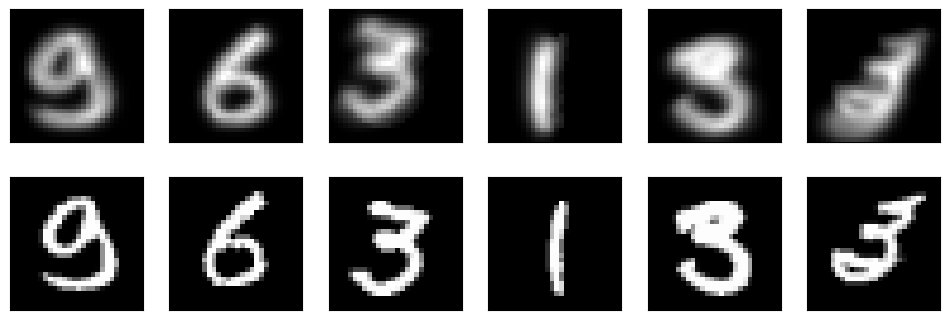

In [14]:
def plot(x, y):
  no = x.shape[0]
  plt.figure(figsize=(2*no, 4))
  for i in range(no):
    # display original
    ax = plt.subplot(2, no, i + 1)
    plt.imshow(x[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, no, i + 1 + no)
    plt.imshow(y[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

  plt.show()

x,y = next(generator(x_test, 6))
plot(x,y)